In [6]:
import pandas as pd
import librosa
import os
import numpy as np 
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder


In [2]:
import tensorflow as  tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [4]:
pip show tensorflow

Name: tensorflow
Version: 2.14.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: e:\mdne\.venv\lib\site-packages
Requires: tensorflow-intel
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [7]:
audio_path = 'spectogram/'
spectograms = os.listdir(audio_path)


In [8]:


def get_label(filename):

    metadata = pd.read_csv('metadata.csv', sep = ',')
    chords = {}

    png_name = filename.replace('.png', '.wav')
    chord = metadata[metadata['Filename'] == png_name]['Acorde'].values[0]

    return chord


In [9]:
from keras.preprocessing import image
# ref -> https://github.com/jeffprosise/Deep-Learning/blob/master/Audio%20Classification%20(CNN).ipynb
def load_images_from_path(path):
    images = []
    labels = []

    for file in os.listdir(path):
        images.append(image.img_to_array(image.load_img(os.path.join(path, file), target_size=(224, 224, 3))))
        labels.append(get_label(file))
    return images,labels     


img_np, labels = load_images_from_path(audio_path)

In [10]:
code = np.array(labels)

label_encoder = LabelEncoder()
int_labels = label_encoder.fit_transform(code)

# mapeando acordes para o número de codificação
mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))


x_train, x_test, y_train, y_test = train_test_split(img_np, int_labels, stratify=int_labels, test_size=0.3, random_state=0)

x_train_norm = np.array(x_train) / 255
x_test_norm = np.array(x_test) / 255


y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)



In [15]:

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(42, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 128)     36992     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 128)       147584    
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 26, 26, 128)      

In [16]:
hist = model.fit(x_train_norm, y_train_encoded, validation_data=(x_test_norm, y_test_encoded), batch_size=10, epochs=10)

Epoch 1/10
 63/107 [================>.............] - ETA: 40s - loss: 3.6315 - accuracy: 0.0492

KeyboardInterrupt: 

[]

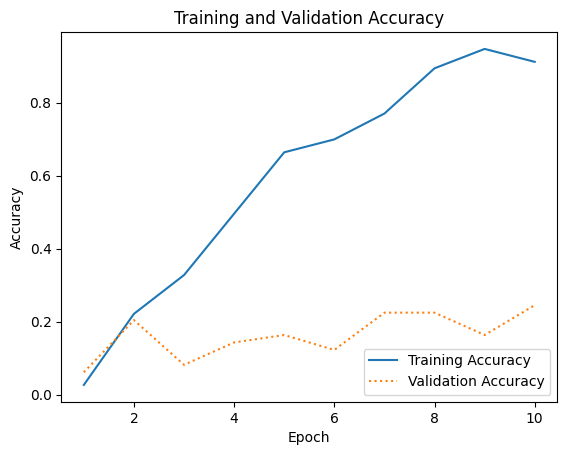

In [15]:
import matplotlib.pyplot as plt

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

## Transfer Learning

In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x_train_norm = preprocess_input(np.array(x_train))
x_test_norm = preprocess_input(np.array(x_test))

train_features = base_model.predict(x_train_norm)
test_features = base_model.predict(x_test_norm)

NameError: name 'x_train' is not defined

In [12]:


model = Sequential()
model.add(Flatten(input_shape=train_features.shape[1:]))
model.add(Dense(1024, activation='relu'))
model.add(Dense(34, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [13]:
hist = model.fit(train_features, y_train_encoded, validation_data=(test_features, y_test_encoded), batch_size=10, epochs=10)

Epoch 1/10
12/12 [==============================] - 14s 1s/step - loss: 95.3311 - accuracy: 0.0265 - val_loss: 68.0953 - val_accuracy: 0.0612
Epoch 2/10
12/12 [==============================] - 12s 968ms/step - loss: 33.3391 - accuracy: 0.2212 - val_loss: 33.0259 - val_accuracy: 0.2041
Epoch 3/10
12/12 [==============================] - 11s 949ms/step - loss: 14.4222 - accuracy: 0.3274 - val_loss: 20.7822 - val_accuracy: 0.0816
Epoch 4/10
12/12 [==============================] - 12s 978ms/step - loss: 5.2612 - accuracy: 0.4956 - val_loss: 12.4643 - val_accuracy: 0.1429
Epoch 5/10
12/12 [==============================] - 11s 955ms/step - loss: 2.1387 - accuracy: 0.6637 - val_loss: 12.1187 - val_accuracy: 0.1633
Epoch 6/10
12/12 [==============================] - 11s 948ms/step - loss: 1.5767 - accuracy: 0.6991 - val_loss: 8.9737 - val_accuracy: 0.1224
Epoch 7/10
12/12 [==============================] - 13s 1s/step - loss: 1.2980 - accuracy: 0.7699 - val_loss: 9.6751 - val_accuracy: 0.22

[]

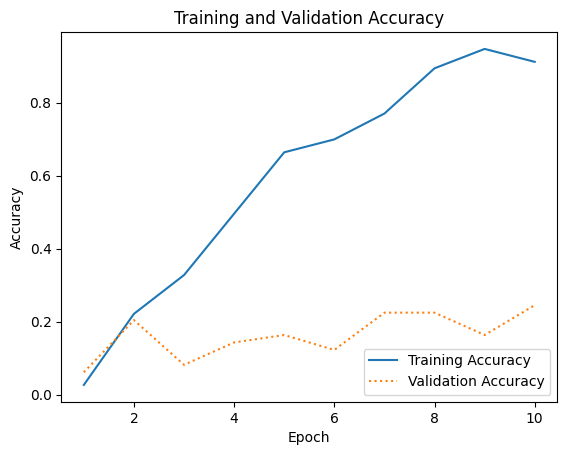

In [16]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()